In [1]:
# what's a raymarshing

In [1305]:
import math
import numpy as np
import matplotlib.pyplot as plt
import ipdb
plt.rcParams["figure.figsize"] = (6,6)

In [1306]:
H = 100
W = 100
Z = 0

K_a = np.array([0.2, 0.2, 0.2])
K_d = np.array([0.7, 0.2, 0.2])
K_s = np.array([1.0, 1.0, 1.0])
shininess = 0.2
    

class DetectorSquare():
    def __init__(self, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)
        
class Ray():
    def __init__(self, location, vector, pixel):
        self.range = 0
        self.active = True
        self.energy = 0
        self.location = np.array(location)
        self.vector = np.array(vector)
        self.pixel = pixel
        self.color = [0,0,0]

In [1307]:
rays = []
origin = np.array([0, 0, 5])
detector = DetectorSquare(H,W,-5)

#create rays from ORIGIN to pixel at DetectorSquare
for i in range(W):
    for j in range(H):
        rays.append(Ray(location = [detector.xes[i],detector.yes[j],detector.z1],
                         vector = [detector.xes[i],detector.yes[j],detector.z1] - origin,
                         pixel = [i,j]))

In [1308]:
length = lambda x: math.sqrt((x**2).sum())

def sphereSDF(p):  return length(p) - 4

def displace_point_along_vector(p0,vector,d):
    return p0 + vector/np.linalg.norm(vector)*d

def normalize(v): return v/np.linalg.norm(np.array(v))

def reflect(d,n):
    return d - 2*(np.dot(d,n))*normalize(d)

In [1309]:
EPSILON=1e-5

def estimateNormal(point):
    return normalize(np.array([
        sphereSDF(np.array([point[0]+EPSILON, point[1], point[2]])-sphereSDF(np.array([point[0]-EPSILON, point[1], point[2]]))),
        sphereSDF(np.array([point[0], point[1]+EPSILON, point[2]])-sphereSDF(np.array([point[0], point[1]-EPSILON, point[2]]))),
        sphereSDF(np.array([point[0], point[1], point[2]+EPSILON])-sphereSDF(np.array([point[0], point[1], point[2]-EPSILON])))]))
    
    
def phongContribForLight(k_d, k_s, alpha, p, eye, light1Pos,  light1Intensity):
    N = estimateNormal(p);
    L = normalize(light1Pos - p);
    V = normalize(eye - p);

    R = normalize(reflect(-L, N));
    
    dotLN = np.dot(L, N);
    dotRV = np.dot(R, V);

    if (dotLN < 0.0):
        return [0.0, 0.0, 0.0];
    
    if (dotRV < 0.0):
        return light1Intensity * (k_d * dotLN);
#     pdb.set_trace()
    
    return light1Intensity * (k_d * dotLN + k_s * np.power(dotRV, alpha));
    
def get_phong_color(k_a, k_d, k_s, alpha, p, eye):
    ambientLight = np.array([0.5,0.5,0.5])
    color = ambientLight * K_a
    light1Pos = np.array([103, 5, -6])
    light1Intensity = np.array([0., 0.9, 0.2])
#     ipdb.set_trace()
    color = phongContribForLight(k_d, k_s, alpha, p, eye, light1Pos, light1Intensity)
    
    
#     light2Pos = [7, 1, 3]
#     light2Intensity = [0.2, 0., 0.4]
    
#     color += phongContribForLight(k_d, k_s, alpha, p, eye, light2Pos, light2Intensity)
    
    
    return color
    
    


In [1310]:
while all([ray.active for ray in rays]):
    for q, ray in enumerate([x for x in rays if x.active]):
        save_displace = sphereSDF(ray.location)
        if (save_displace > 100): 
            ray.active = False
        if save_displace < 0.001: 
            ray.energy = 1
            ray.active = False
            rays[q].color = get_phong_color(K_a, K_d, K_s, shininess, ray.location, origin)
        ray.location = displace_point_along_vector(ray.location, ray.vector, -save_displace)
        

In [1311]:
energy_map = np.zeros((W,H,3))

In [1312]:
for ray in rays:
    energy_map[ray.pixel[0],ray.pixel[1],:] = ray.color

In [1313]:
energy_map.max()

0.6179166771718638

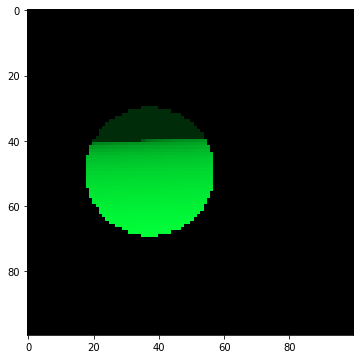

In [1314]:
plt.imshow(energy_map/energy_map.max())
plt.show()

In [1300]:
def plot(shine=1, ):
    rays = []
    origin = np.array([0, 0, 5])
    detector = DetectorSquare(H,W,-5)
    shininess = shine
    #create rays from ORIGIN to pixel at DetectorSquare
    for i in range(W):
        for j in range(H):
            rays.append(Ray(location = [detector.xes[i],detector.yes[j],detector.z1],
                             vector = [detector.xes[i],detector.yes[j],detector.z1] - origin,
                             pixel = [i,j]))
    while all([ray.active for ray in rays]):
        for q, ray in enumerate([x for x in rays if x.active]):
            save_displace = sphereSDF(ray.location)
            if (save_displace > 100): 
                ray.active = False
            if save_displace < 0.001: 
                ray.energy = 1
                ray.active = False
                rays[q].color = get_phong_color(K_a, K_d, K_s, shininess, ray.location, origin)
            ray.location = displace_point_along_vector(ray.location, ray.vector, -save_displace)
    energy_map = np.zeros((W,H,3))
    for ray in rays:
        energy_map[ray.pixel[0],ray.pixel[1],:] = ray.color
    
    plt.imshow(energy_map/energy_map.max())
    plt.show()

In [1301]:
# IMPLEMENT ANOTHER SDF HERE if you like

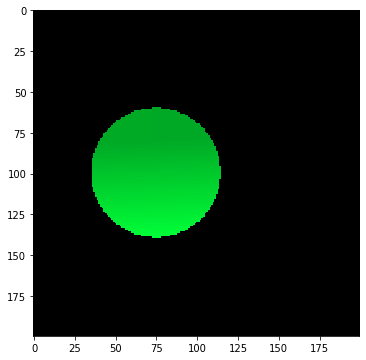

In [1302]:
plot()

In [1303]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [1304]:
interact(plot, shine=(0,1,0.1))

interactive(children=(FloatSlider(value=1.0, description='shine', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.plot(shine=1)>